# Actividad 6
____________________

- Jose Israel Perez Ontiveros | A01423294
- Maximiliano Romero Budib | A01732008
- Ángel Rubén Vazquez Rivera | A0173540


## Descripcion
En la presente actividad se llevara a cabo la busqueda del mejor modelo de regresion lineal multiple de diferentes conjuntos de datos contenidos en un mismo dataframe.

### 1. Importar librerias

In [2]:
#Instalamos la librería para análisis de variables categóricas
%pip install funpymodeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from funpymodeling.exploratory import freq_tbl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


Note: you may need to restart the kernel to use updated packages.


### 2. Cargar Archivo

In [3]:
data = pd.read_csv("./Recursos/TrainingDataComplete.csv", index_col=0)
display(data)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0


### 3. Preprocesamiento (Nulos y Outliers)

- 3.1 Verificamos info del DF

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


In [5]:
# Separamos columnas cuantitativas y cualitativas
dataCualitativas  = data.iloc[: , [3, 4, 5, 6, 7, 8, 11]]
dataCuantitativas = data.iloc[: , [0, 1, 2, 9, 10]]

print(f'Columnas cualitativas: {dataCualitativas.columns}')
print(f'\n\nColumnas cuantitativas: {dataCuantitativas.columns}')

Columnas cualitativas: Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE', 'Risk_Flag'],
      dtype='object')


Columnas cuantitativas: Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], dtype='object')


In [6]:
# Verificamos que no hayan valores nulos
valores_nulos = dataCuantitativas.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64


Al no encontrar valores nulos podemos avanzar a la identificación de outliers

- 3.2 Diagrama de bigote

<Figure size 1500x800 with 0 Axes>

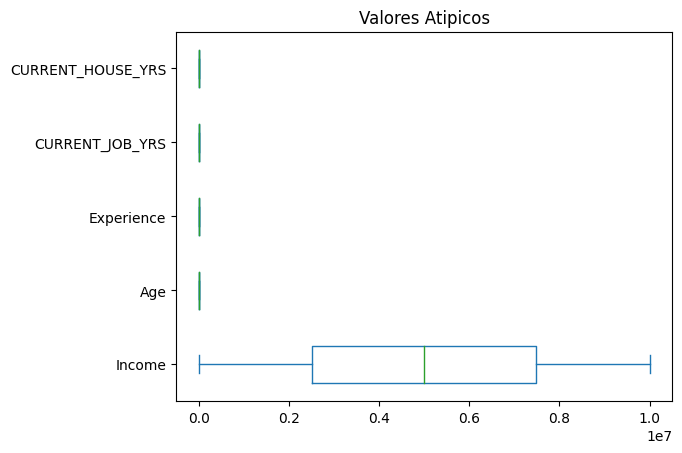

In [7]:
fig = plt.figure(figsize = (15, 8))
dataCuantitativas.plot(kind='box', vert=False)
plt.title('Valores Atipicos')
plt.show()

- 3.3 Metodo de cuantiles

In [8]:
# Encontramos los valores extremos
y = dataCuantitativas

percentile25 = y.quantile(0.25) #Q1
percentile75 = y.quantile(0.75) #Q3

iqr = percentile75 - percentile25

limiteSuperiorIQR = percentile75 + 1.5 * iqr
limiteInferiorIQR = percentile25 - 1.5 * iqr


print(f"Limite superior permitido :")
for col, val in limiteSuperiorIQR.items():
    print(f"{col}: {round(val, 2)}")

print(f"\n\nLimite inferior permitido :")
for col, val in limiteInferiorIQR.items():
    print(f"{col}: {round(val, 2)}")

Limite superior permitido :
Income: 14939232.5
Age: 110.0
Experience: 30.0
CURRENT_JOB_YRS: 18.0
CURRENT_HOUSE_YRS: 16.0


Limite inferior permitido :
Income: -4958715.5
Age: -10.0
Experience: -10.0
CURRENT_JOB_YRS: -6.0
CURRENT_HOUSE_YRS: 8.0


- 3.4 Busqueda de Outliers

In [9]:
# Encontramos Outliers
outliers = dataCuantitativas[(y>limiteSuperiorIQR) | (y<limiteInferiorIQR)]
print(f"\nOutliers:\n")
for col, val in outliers.items():
    print(f"{col}: {round(val, 2)}")


Outliers:

Income: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Income, Length: 252000, dtype: float64
Age: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Age, Length: 252000, dtype: float64
Experience: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Experience, Length: 252000, dtype: float64
CURRENT_JOB_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: CURRENT_JOB_YRS, Length: 252000, dtype: float64
CURRENT_HOUSE_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: C

- 3.5 Convertir outliers en nulos

In [10]:
dataIqr = dataCuantitativas[(y<=limiteSuperiorIQR) & (y>=limiteInferiorIQR)]
display(dataIqr)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,
1,1303834,23,3,3,13
2,7574516,40,10,9,13
3,3991815,66,4,4,10
4,6256451,41,2,2,12
5,5768871,47,11,3,14
...,...,...,...,...,...
251996,8154883,43,13,6,11
251997,2843572,26,10,6,11
251998,4522448,46,7,7,12


In [11]:
# Corroboramos valores nulos
valores_nulos = dataIqr.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64


##### Nota. Al no encontrar valores nulos podemos inferir que no existen valores atipicos y nuestros datos se encuentran limpios.

- 3.6 Unimos las columnas cuantitativas con las cualitativas

In [12]:
dataClean = pd.concat([dataCualitativas, dataIqr], axis=1)
display(dataClean)

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,,,,,
1,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,0,1303834,23,3,3,13
2,single,rented,no,Software_Developer,Parbhani,Maharashtra,0,7574516,40,10,9,13
3,married,rented,no,Technical_writer,Alappuzha,Kerala,0,3991815,66,4,4,10
4,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,1,6256451,41,2,2,12
5,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,single,rented,no,Surgeon,Kolkata,West_Bengal,0,8154883,43,13,6,11
251997,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,0,2843572,26,10,6,11
251998,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,0,4522448,46,7,7,12


### 4. Extraccion de caracteristicas

Dentro de este proceso se busca extraer caracteristicas relevantes de los datos presentes en cada una de las columnas de nuestro DF.

- 4.1 Columna Age

Como se observa en la gráfica de barras, en los datos encontramos un rango amplio de edades que va desde 21 - 79 años de edad. De misma forma, realizamos un analisis para ver si la edad es factor para definir si una personas se encuentra en estado de riesgo o no (como se muestra en la gráfica de pastel), sin embargo, vemos que de igual manera, hay variedad en edades, por lo que no podriamos decir que la edad es un factor

Text(0, 0.5, 'Personas')

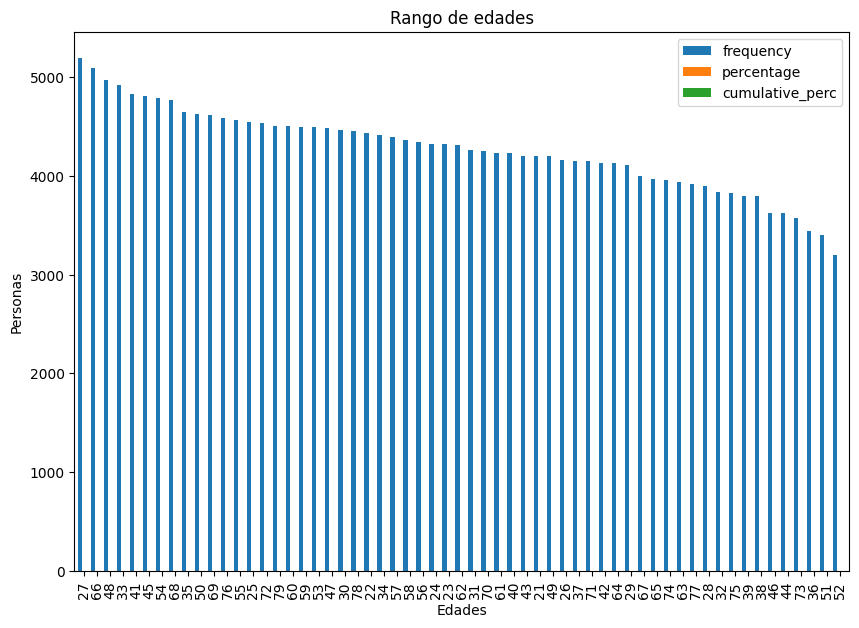

In [13]:
table = freq_tbl(dataClean['Age'].astype("string"))
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("Age")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
plt.title('Rango de edades')
plt.xlabel('Edades')
plt.ylabel('Personas')

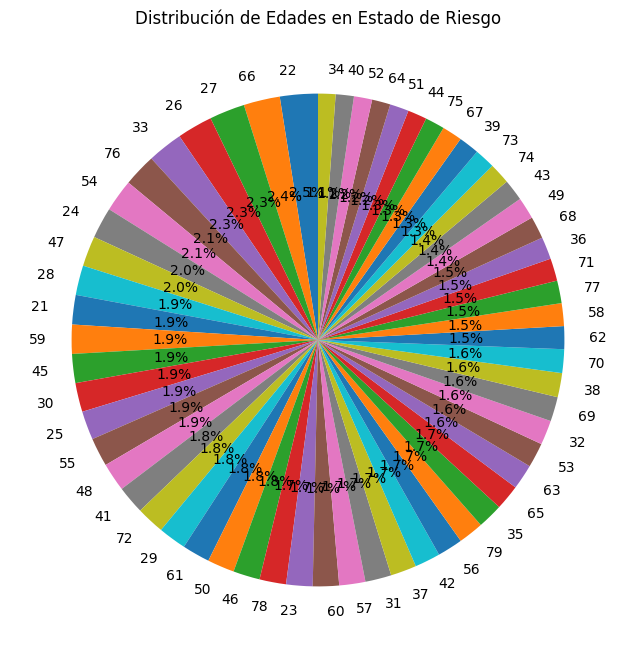

In [14]:
filtro = dataClean[dataClean['Risk_Flag'] == 1]

edadesRiesgo = filtro['Age'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(edadesRiesgo, labels=edadesRiesgo.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Edades en Estado de Riesgo')
plt.show()

- 4.2 Columna Experience

Como se muestra en la gráfica de barras, encontramos en los datos a gente inexperta como experta en su área y va de 0 - 20 años de experiencia

Text(0, 0.5, 'Personas')

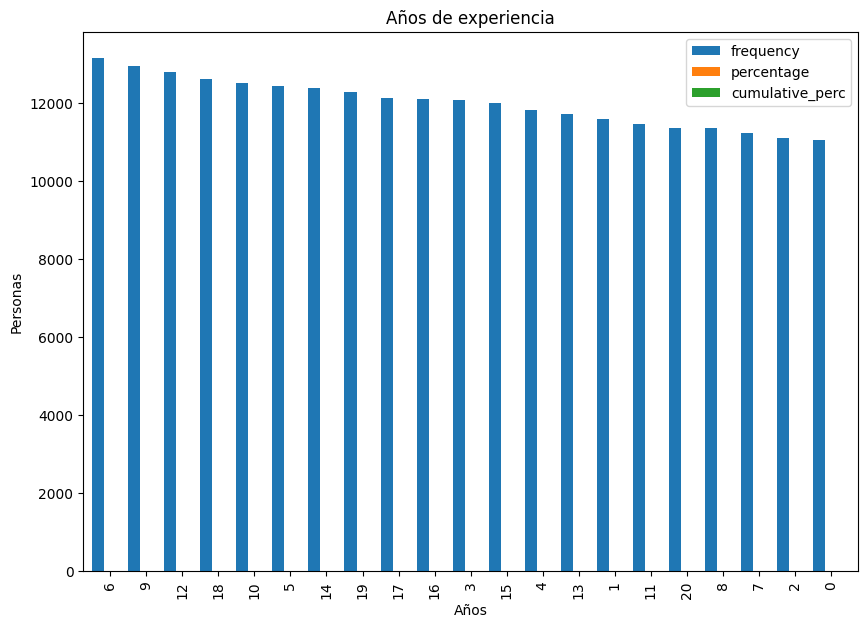

In [15]:
table = freq_tbl(dataClean['Experience'].astype("string"))
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("Experience")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
plt.title('Años de experiencia')
plt.xlabel('Años')
plt.ylabel('Personas')

- 4.3 Columna Married/Single

Como se muestra en la gráfica de pastel, vemos que la mayor parte de la población se encuentra soltera (89.8%), mientras que solo el 10.2% se encuentra casada. Por tanto, hay 226,272 personas solteras y 25,728 personas casadas.

,Married/Single,frequency,percentage,cumulative_perc
0,single,226272,0.897905,0.897905
1,married,25728,0.102095,1.000000


Personas solteras: 226272
Personas casadas: 25728


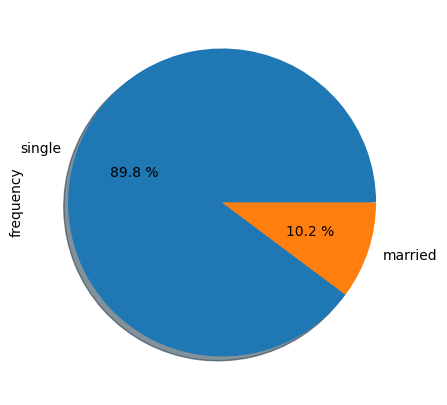

In [16]:
table = freq_tbl(dataClean['Married/Single'])
display(table)
Filtro = table[table['frequency'] > 1]
Filtro_setter = Filtro.set_index("Married/Single")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")

print(f"Personas solteras: {Filtro['frequency'][0]}")
print(f"Personas casadas: {Filtro['frequency'][1]}")


- 4.4 Columna House_Ownership

Como se muestra en la gráfica de pastel la mayor parte de la población renta, siendo el 92% de la poblacion (231,898 personas), mientras que solo el 5.1% de la población es dueña de algun espacio (12,918 personas) y el resto no renta ni es dueña de alguna propiedad (7184 personas)

Personas rentando: 231898
Personas con propiedad: 12918
Personas sin propiedad ni renta: 7184


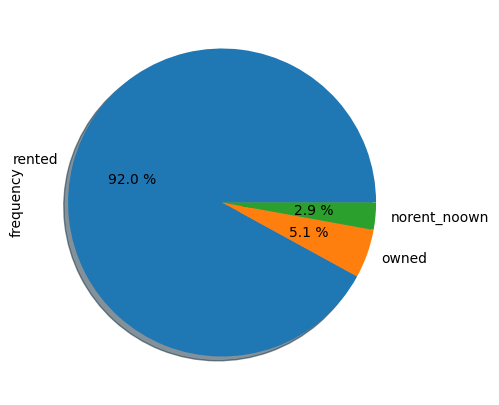

In [17]:
table = freq_tbl(dataClean['House_Ownership'])
Filtro = table[table['frequency'] > 20]
Filtro_setter = Filtro.set_index("House_Ownership")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")

cantidadRegistros = dataClean.shape[0]

print(f"Personas rentando: {Filtro['frequency'][0]}")
print(f"Personas con propiedad: {Filtro['frequency'][1]}")
print(f"Personas sin propiedad ni renta: {Filtro['frequency'][2]}")


- 4.5 Columna Profession

Como se muestra en la gráfica de barras contamos con 51 tipos de profesiones distintas así como de áreas distintas

Profesiones distintas: 51


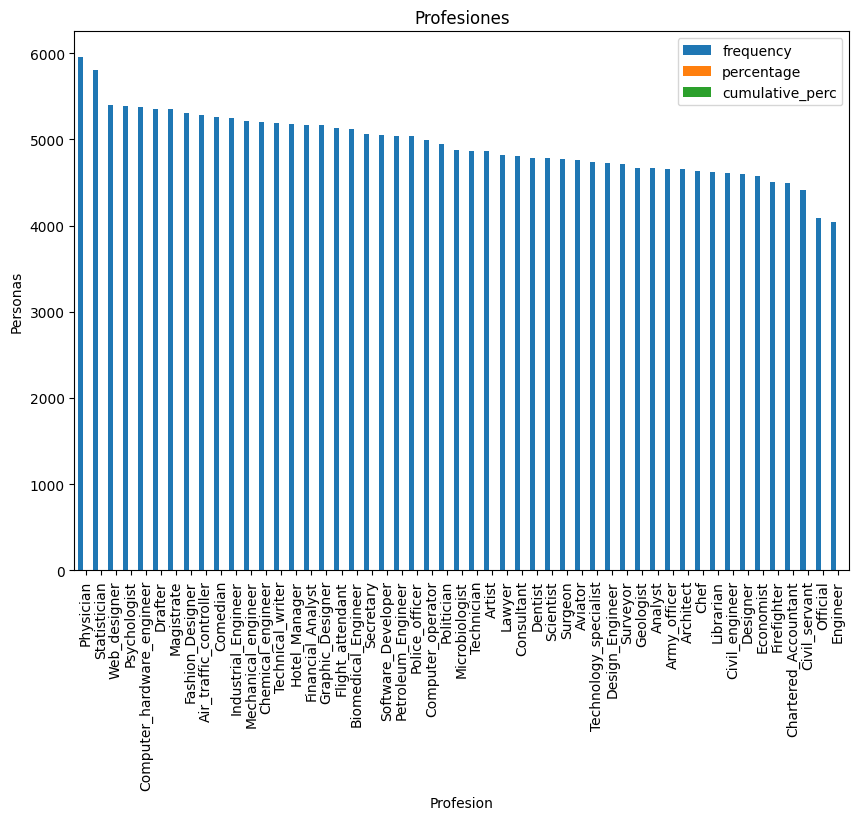

In [18]:
table = freq_tbl(dataClean['Profession'])
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("Profession")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
plt.title('Profesiones')
plt.xlabel('Profesion')
plt.ylabel('Personas')

print(f'Profesiones distintas: {table["Profession"].shape[0]}')

- 4.6 Columna CITY

En un analisis previo podemos confirmar que existen 317 ciudades distintas, por lo que desplegarlas en una misma tabla pueda a llegar a ser confuso por la contener demasiada información en un espacio reducido. Por tanto, se decidió mostrar unicamente las 20 ciudades más populares dentro del DF, siendo Vijayanaram la ciudad más popular entre los datos.

Ciudades distintas: 317


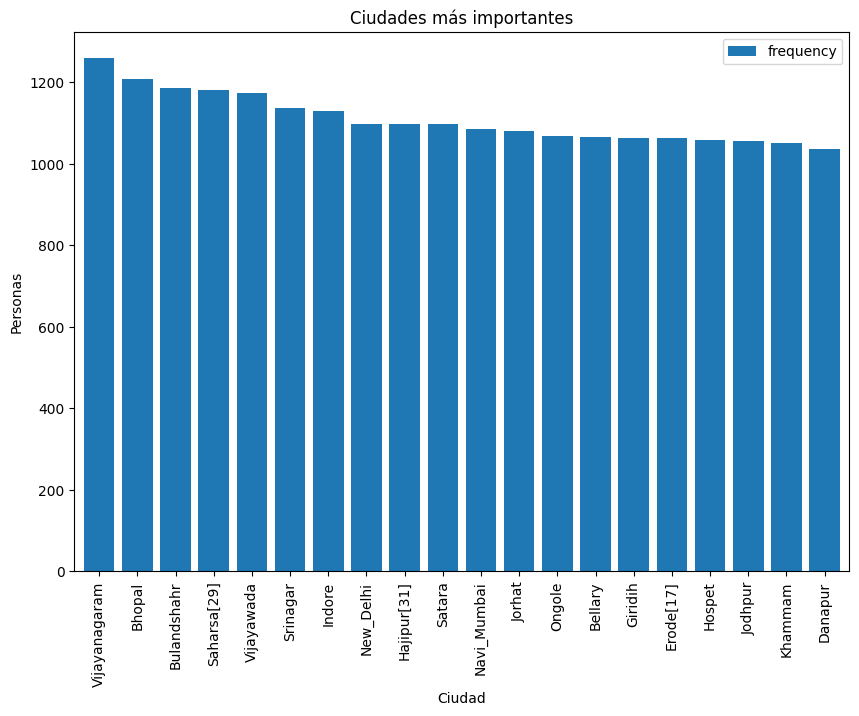

In [19]:
table = freq_tbl(dataClean['CITY'])
Filtro = table.sort_values(by='frequency', ascending=False).head(20)

Filtro.plot(kind="bar", x="CITY", y="frequency", width=0.8, figsize=(10, 7))
plt.title('Ciudades más importantes')
plt.xlabel('Ciudad')
plt.ylabel('Personas')

print(f'Ciudades distintas: {table["CITY"].shape[0]}')

- 4.7 Columna CURRENT_JOB_YRS

Como se muestra en la gráfica de barras, encontramos en los datos gente empezando en una empresa nueva así como veteranos dentro de una empresa, los años van de 0 - 14

Text(0, 0.5, 'Personas')

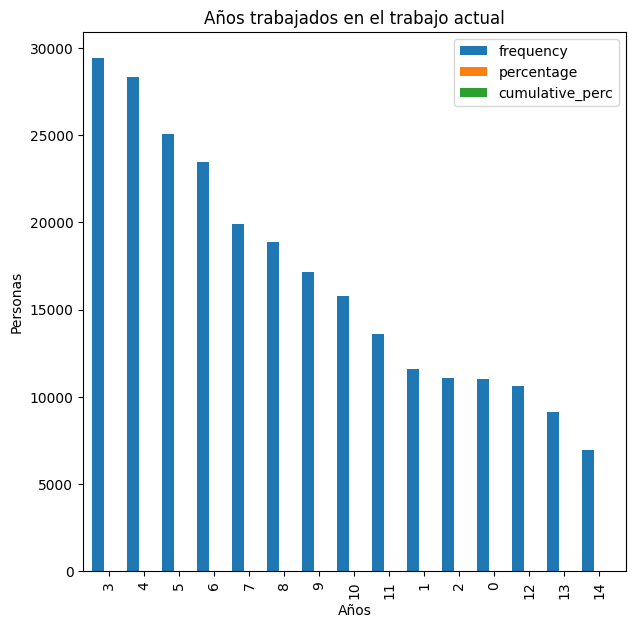

In [20]:
table = freq_tbl(dataClean['CURRENT_JOB_YRS'].astype("string"))
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("CURRENT_JOB_YRS")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(7,7))
plt.title('Años trabajados en el trabajo actual')
plt.xlabel('Años')
plt.ylabel('Personas')

- 4.8 Columna CURRENT_HOUSE_YRS

Como se muestra en la gráfica de pastel todas las personas dentro de los datos proporcionados llevan un minimo de 10 años dentro de una misma residencia y hasta con 14 años habitando el mismo lugar.

,CURRENT_HOUSE_YRS,frequency,percentage,cumulative_perc
0,11,51873,0.205845,0.205845
1,12,51791,0.20552,0.411365
2,13,50659,0.201028,0.612393
3,14,49003,0.194456,0.806849
4,10,48674,0.193151,1.0


<Axes: ylabel='frequency'>

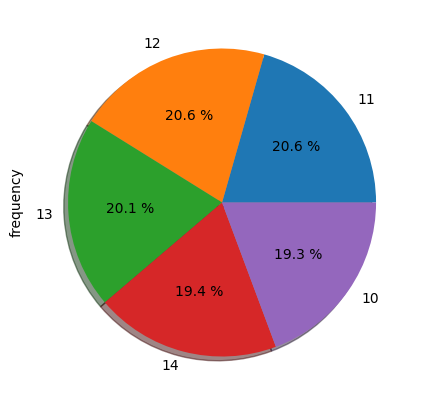

In [21]:
table = freq_tbl(dataClean['CURRENT_HOUSE_YRS'].astype("string"))
display(table)
Filtro = table[table['frequency'] > 20]
Filtro_setter = Filtro.set_index("CURRENT_HOUSE_YRS")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")


- 4.9 Columna Risk_Flag

Como se muestra en la gráfica de pastel, el 87.7% de la población no se encuentra en satus de riesgo (221,004 personas), mientras que el 12.3% lo está (30,996 personas)

Personas sin riesgo: 221004
Personas en riesgo: 30996


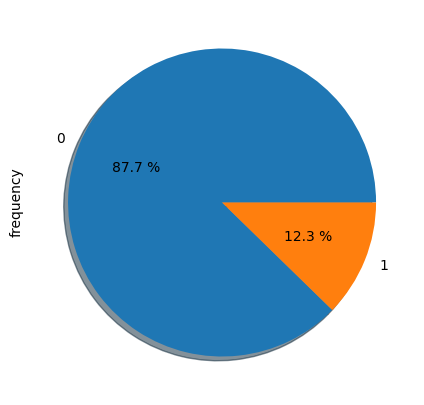

In [22]:
table = freq_tbl(dataClean['Risk_Flag'].astype("string"))
Filtro = table[table['frequency'] > 2]
Filtro_setter = Filtro.set_index("Risk_Flag")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")

print(f'Personas sin riesgo: {table["frequency"][0]}')
print(f'Personas en riesgo: {table["frequency"][1]}')

### 5. Encontrar los 3 mejores modelos de regresion lineal simple

- 5.1 Separamos variables cualitativas de cuantitativas

In [23]:
dataClean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Married/Single     252000 non-null  object
 1   House_Ownership    252000 non-null  object
 2   Car_Ownership      252000 non-null  object
 3   Profession         252000 non-null  object
 4   CITY               252000 non-null  object
 5   STATE              252000 non-null  object
 6   Risk_Flag          252000 non-null  int64 
 7   Income             252000 non-null  int64 
 8   Age                252000 non-null  int64 
 9   Experience         252000 non-null  int64 
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


In [24]:
dataCualitativas  = dataClean.iloc[: , [0, 1, 2, 3, 4, 5]]
dataCuantitativas = dataClean.iloc[: , [6, 7, 8, 9, 10, 11]]

print(f'Columnas cualitativas: {dataCualitativas.columns}')
print(f'\n\nColumnas cuantitativas: {dataCuantitativas.columns}')

Columnas cualitativas: Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE'],
      dtype='object')


Columnas cuantitativas: Index(['Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS'],
      dtype='object')


- 5.2 Graficamos todas las dispersiones entre todas las variables


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


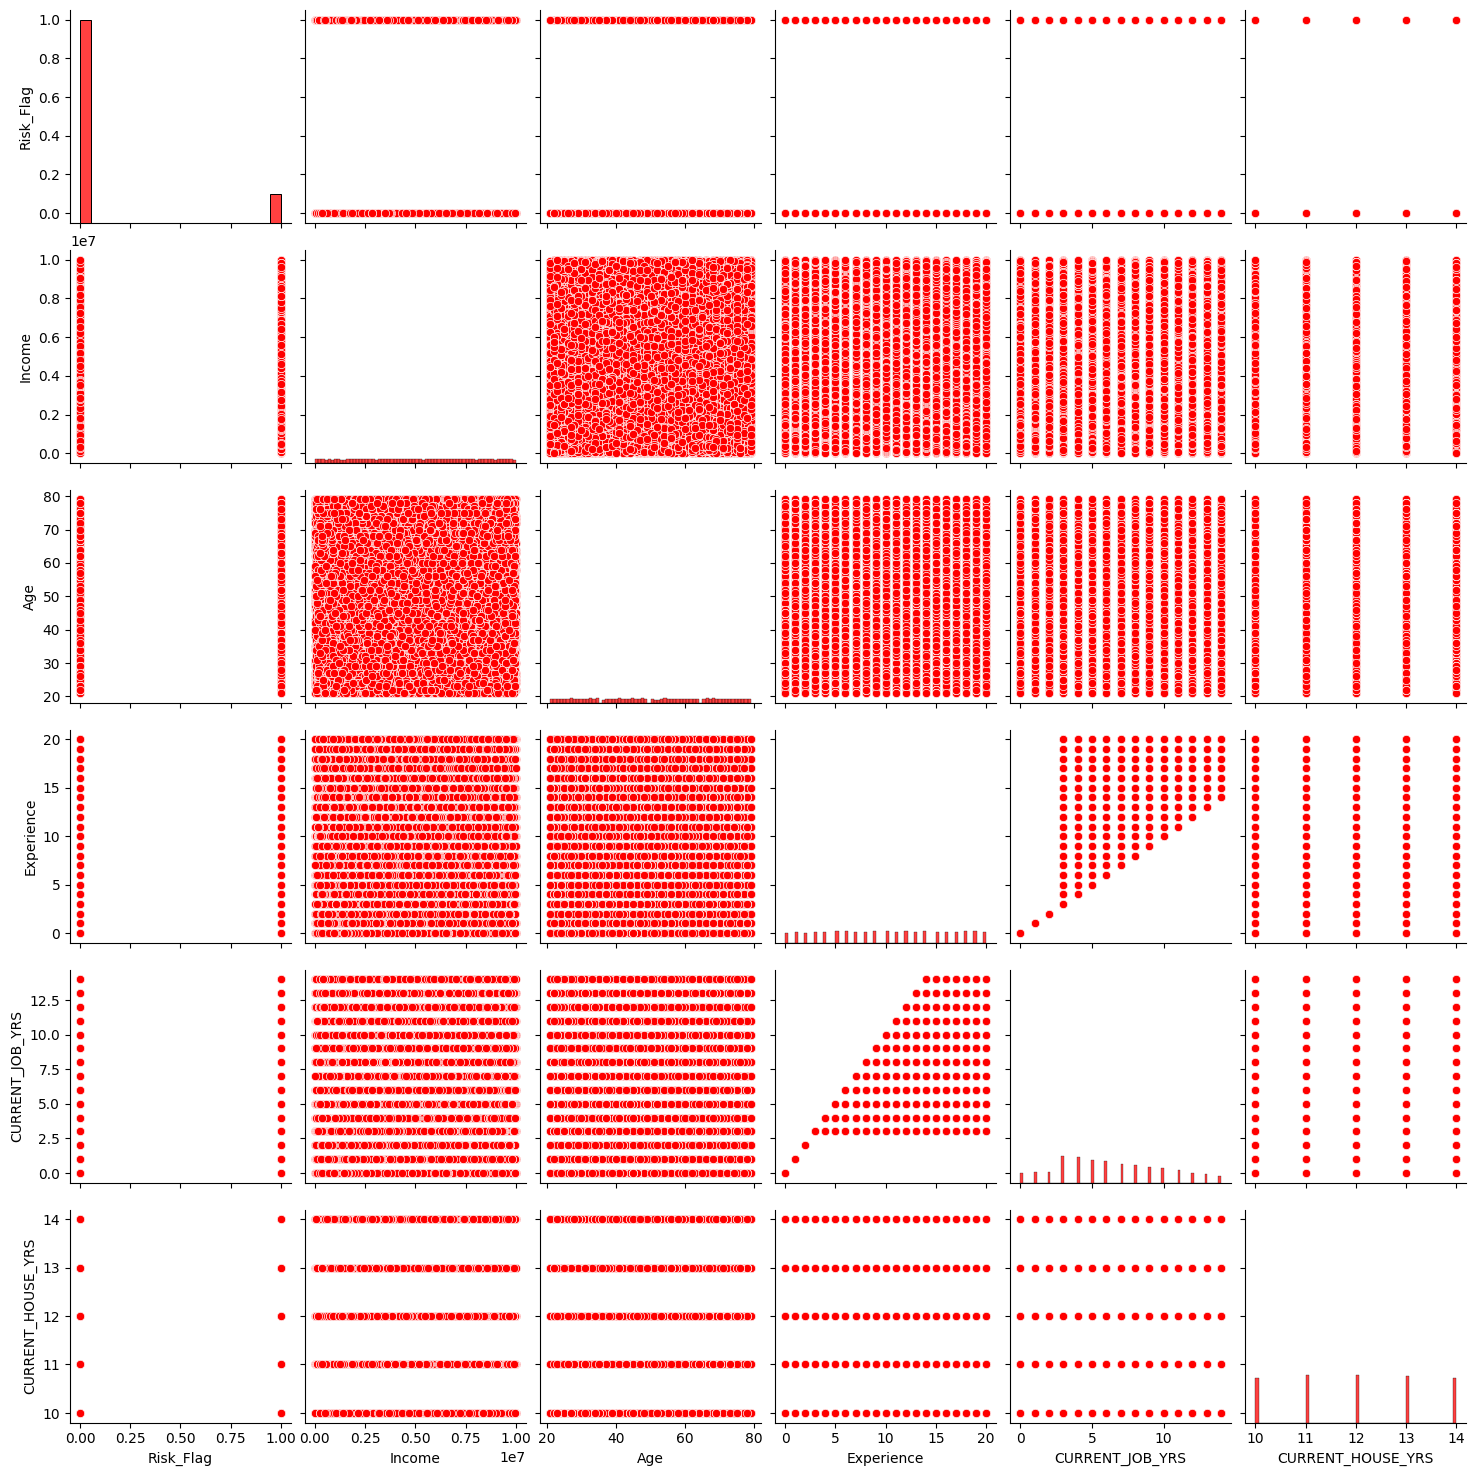

In [25]:
sns.pairplot(dataCuantitativas, diag_kws={'color': 'red'}, plot_kws={'color': 'red'})

In [26]:
#Encontramos todas las correlaciones entre las variables
Corr_Factors=dataCuantitativas.corr()
Corr_Factors

,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Risk_Flag,1.000000,-0.003091,-0.021809,-0.034523,-0.016942,-0.004375
Income,-0.003091,1.000000,-0.000652,0.006422,0.007045,-0.002397
Age,-0.021809,-0.000652,1.000000,-0.001118,0.002154,-0.020134
Experience,-0.034523,0.006422,-0.001118,1.000000,0.646098,0.019309
CURRENT_JOB_YRS,-0.016942,0.007045,0.002154,0.646098,1.000000,0.005372
CURRENT_HOUSE_YRS,-0.004375,-0.002397,-0.020134,0.019309,0.005372,1.000000


In [27]:
#Encontramos el valor absoluto de todas las correlaciones entre las variables
Corr_Factors1= abs(Corr_Factors)
Corr_Factors1

,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Risk_Flag,1.000000,0.003091,0.021809,0.034523,0.016942,0.004375
Income,0.003091,1.000000,0.000652,0.006422,0.007045,0.002397
Age,0.021809,0.000652,1.000000,0.001118,0.002154,0.020134
Experience,0.034523,0.006422,0.001118,1.000000,0.646098,0.019309
CURRENT_JOB_YRS,0.016942,0.007045,0.002154,0.646098,1.000000,0.005372
CURRENT_HOUSE_YRS,0.004375,0.002397,0.020134,0.019309,0.005372,1.000000


- 5.3 Mapa de calor

<Axes: >

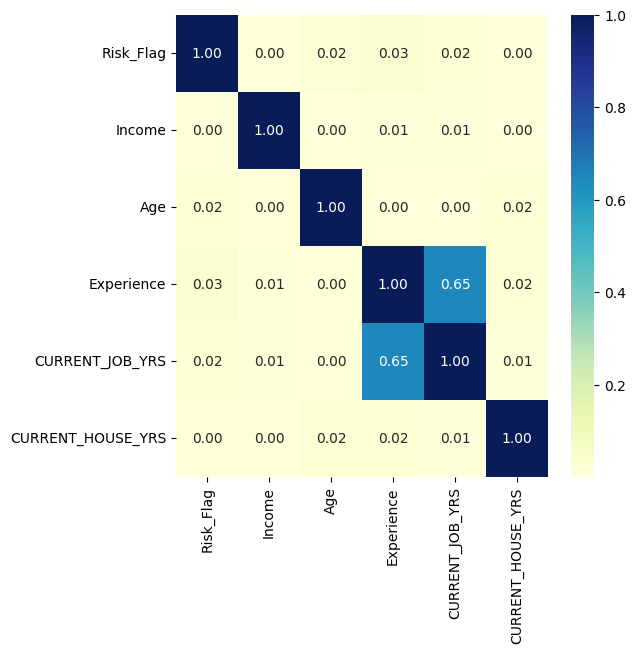

In [28]:
plt.figure(figsize=(6, 6))
#Graficamos el mapa de calor de los coeficientes de correlación
Heat_Map = sns.heatmap(Corr_Factors1, cmap='YlGnBu', annot = True, fmt=".2f")
display(Heat_Map)

- 5.4 Regresion lineal simple


<Axes: xlabel='CURRENT_JOB_YRS', ylabel='Experience'>

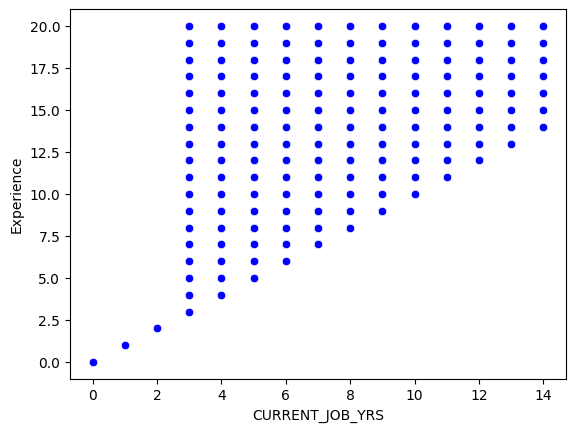

In [29]:
sns.scatterplot(x='CURRENT_JOB_YRS', y='Experience', color="blue", data=dataCuantitativas)


In [30]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_Indep= dataCuantitativas[['CURRENT_JOB_YRS']]
Var_Dep= dataCuantitativas['Experience']

In [31]:
#Se define model como la función de regresión lineal
model= LinearRegression()

#Ajustamos el modelo con las variables antes declaradas
model.fit(X=Vars_Indep, y=Var_Dep)

LinearRegression()

In [32]:
#Verificamos los coeficientes obtenidos para el modelo ajustado
model.__dict__


{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['CURRENT_JOB_YRS'], dtype=object),
 'n_features_in_': 1,
 'coef_': array([1.06339513]),
 'rank_': 1,
 'singular_': array([1830.80244488]),
 'intercept_': 3.3490225813824326}

In [33]:
# Modelo Matematico 1.06339513x + 3.3490225813824326
y_pred= model.predict(X=dataCuantitativas[['CURRENT_JOB_YRS']])
y_pred

array([ 6.53920797, 12.91957873,  7.60260309, ..., 10.79278848,
        3.34902258, 10.79278848])

In [34]:
#Insertamos la columna de predicciones en el DataFrame
dataCuantitativas.insert(0, 'PrediccionesRL', y_pred)
dataCuantitativas

,PrediccionesRL,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,
1,6.539208,0,1303834,23,3,3,13
2,12.919579,0,7574516,40,10,9,13
3,7.602603,0,3991815,66,4,4,10
4,5.475813,1,6256451,41,2,2,12
5,6.539208,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...
251996,9.729393,0,8154883,43,13,6,11
251997,9.729393,0,2843572,26,10,6,11
251998,10.792788,0,4522448,46,7,7,12


<Axes: xlabel='CURRENT_JOB_YRS', ylabel='Experience'>

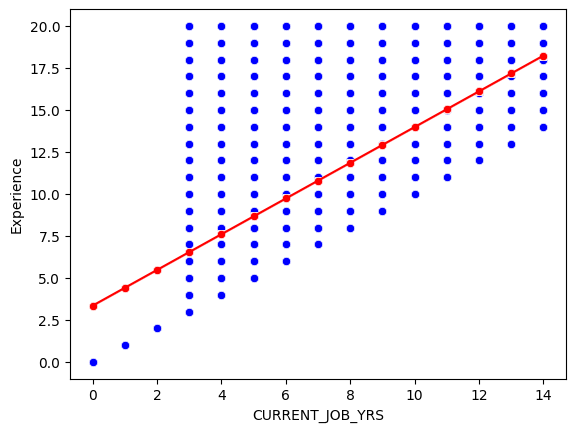

In [35]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_JOB_YRS', y='Experience', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_JOB_YRS', y='PrediccionesRL', color="red", data=dataCuantitativas)
sns.lineplot(x='CURRENT_JOB_YRS', y='PrediccionesRL', color="red", data=dataCuantitativas)

In [36]:
#Corroboramos cual es el coeficiente de Determinación de nuestro modelo
coef_Deter=model.score(X=Vars_Indep, y=Var_Dep)
print(f'Coeficiente de determinacion: {round(coef_Deter,2)}')

Coeficiente de determinacion: 0.42


In [37]:
#Corroboramos cual es el coeficiente de Correlación de nuestro modelo
coef_Correl=np.sqrt(coef_Deter)
print(f'Coeficiente de correlacion: {round(coef_Correl,2)}')

Coeficiente de correlacion: 0.65


### 6. Regresion lineal multiple

- 6.1 Variable Income

In [38]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepIncomeRNL= dataCuantitativas[['Experience', 'Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']]
Var_DepIncomeRNL= dataCuantitativas['Income']

In [39]:
#Se define model como la función de regresión lineal
modelIncome= LinearRegression()

In [40]:
#Ajustamos el modelo con las variables antes declaradas
modelIncome.fit(X=Vars_IndepIncomeRNL, y=Var_DepIncomeRNL)

LinearRegression()

In [41]:
#Verificamos los coeficientes obtenidos para el modelo ajustado
modelIncome.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['Experience', 'Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'],
       dtype=object),
 'n_features_in_': 4,
 'coef_': array([ 1570.49372642,  -119.60460679,  3901.45155326, -5146.0166579 ]),
 'rank_': 4,
 'singular_': array([8565.98351382, 3284.56484425, 1281.99339764,  701.97671005]),
 'intercept_': 5024283.389913401}

In [42]:
#Evaluamos la eficiencia del modelo obtenido por medio del coeficiente R Determinación
modelIncome.score(Vars_IndepIncomeRNL,Var_DepIncomeRNL)

6.23149509521026e-05

In [43]:
#Predecimos los valores de total de accidentes a partir de las variables: "alcohol", "speeding" y "no_previous"
y_predIncome= modelIncome.predict(X=dataCuantitativas[['Experience', 'Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']])
y_predIncome

array([4971050.10324344, 5003418.99033241, 4986817.10040466, ...,
       4995332.99506377, 4967441.01602864, 5013313.43842278])

In [44]:
#Insertamos la columna de predicciones en el DataFrame
dataCuantitativas.insert(0, 'PrediccionesRMIncome', y_predIncome)
dataCuantitativas

,PrediccionesRMIncome,PrediccionesRL,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,
1,4.971050e+06,6.539208,0,1303834,23,3,3,13
2,5.003419e+06,12.919579,0,7574516,40,10,9,13
3,4.986817e+06,7.602603,0,3991815,66,4,4,10
4,4.968571e+06,5.475813,1,6256451,41,2,2,12
5,4.975598e+06,6.539208,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...
251996,5.006359e+06,9.729393,0,8154883,43,13,6,11
251997,5.003681e+06,9.729393,0,2843572,26,10,6,11
251998,4.995333e+06,10.792788,0,4522448,46,7,7,12


<Axes: xlabel='Experience', ylabel='Income'>

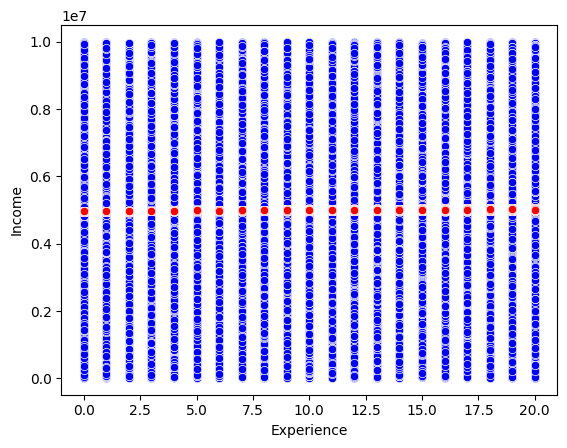

In [45]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Experience', y='Income', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Experience', y='PrediccionesRMIncome', color="red", data=dataCuantitativas)


<Axes: xlabel='Age', ylabel='Income'>

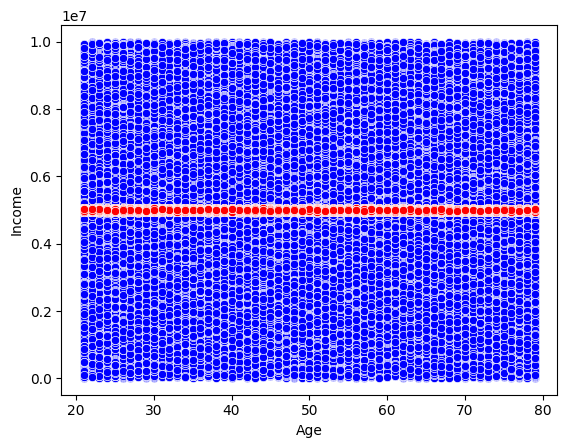

In [46]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Age', y='Income', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Age', y='PrediccionesRMIncome', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_JOB_YRS', ylabel='Income'>

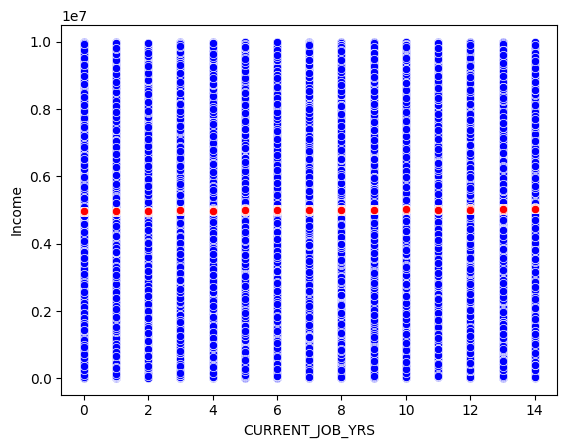

In [47]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_JOB_YRS', y='Income', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_JOB_YRS', y='PrediccionesRMIncome', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_HOUSE_YRS', ylabel='Income'>

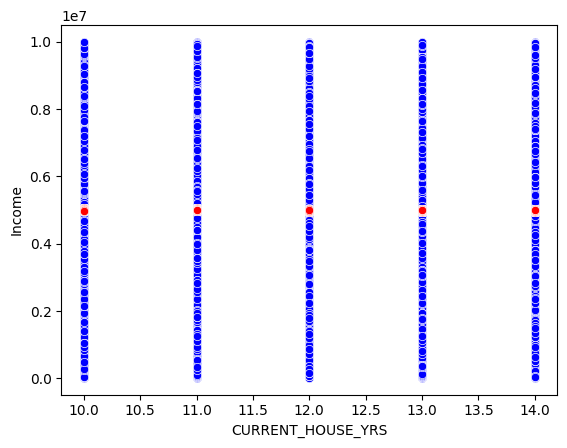

In [48]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_HOUSE_YRS', y='Income', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_HOUSE_YRS', y='PrediccionesRMIncome', color="red", data=dataCuantitativas)


In [49]:
#Corroboramos cual es el coeficiente de Determinación de nuestro modelo
coef_DeterIncome=modelIncome.score(X=Vars_IndepIncomeRNL, y=Var_DepIncomeRNL)
print(f'Coeficiente de determinacion: {coef_DeterIncome}')

Coeficiente de determinacion: 6.23149509521026e-05


In [50]:
#Corroboramos cual es el coeficiente de Correlación de nuestro modelo
coef_CorrelIncome=np.sqrt(coef_DeterIncome)
print(f'Coeficiente de correlacion: {coef_CorrelIncome}')

Coeficiente de correlacion: 0.007893981945260744


- 6.2 Variable Age

In [51]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepAge= dataCuantitativas[['Experience', 'Income', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']]
Var_DepAge= dataCuantitativas['Age']


In [52]:
#Se define model como la función de regresión lineal
modelAge= LinearRegression()

In [53]:
#Ajustamos el modelo con las variables antes declaradas
modelAge.fit(X=Vars_IndepAge, y=Var_DepAge)

LinearRegression()

In [54]:
#Verificamos los coeficientes obtenidos para el modelo ajustado
modelAge.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['Experience', 'Income', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'],
       dtype=object),
 'n_features_in_': 4,
 'coef_': array([-1.06874238e-02, -4.20215153e-09,  2.19728241e-02, -2.45018872e-01]),
 'rank_': 4,
 'singular_': array([1.44489779e+09, 3.28448454e+03, 1.28199978e+03, 7.02116800e+02]),
 'intercept_': 52.88335941845484}

In [55]:
#Evaluamos la eficiencia del modelo obtenido por medio del coeficiente R Determinación
modelAge.score(Vars_IndepAge,Var_DepAge)

0.00041925413579979587

In [56]:
#Predecimos los valores de total de accidentes a partir de las variables: "alcohol", "speeding" y "no_previous"
y_predAge= modelAge.predict(X=dataCuantitativas[['Experience', 'Income', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']])
y_predAge

array([49.72649138, 49.757166  , 50.46153809, ..., 50.00312675,
       50.40582676, 50.12216091])

In [57]:
#Insertamos la columna de predicciones en el DataFrame
dataCuantitativas.insert(0, 'PrediccionesRMAge', y_pred)
dataCuantitativas

,PrediccionesRMAge,PrediccionesRMIncome,PrediccionesRL,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,,
1,6.539208,4.971050e+06,6.539208,0,1303834,23,3,3,13
2,12.919579,5.003419e+06,12.919579,0,7574516,40,10,9,13
3,7.602603,4.986817e+06,7.602603,0,3991815,66,4,4,10
4,5.475813,4.968571e+06,5.475813,1,6256451,41,2,2,12
5,6.539208,4.975598e+06,6.539208,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...,...
251996,9.729393,5.006359e+06,9.729393,0,8154883,43,13,6,11
251997,9.729393,5.003681e+06,9.729393,0,2843572,26,10,6,11
251998,10.792788,4.995333e+06,10.792788,0,4522448,46,7,7,12


<Axes: xlabel='Experience', ylabel='Age'>

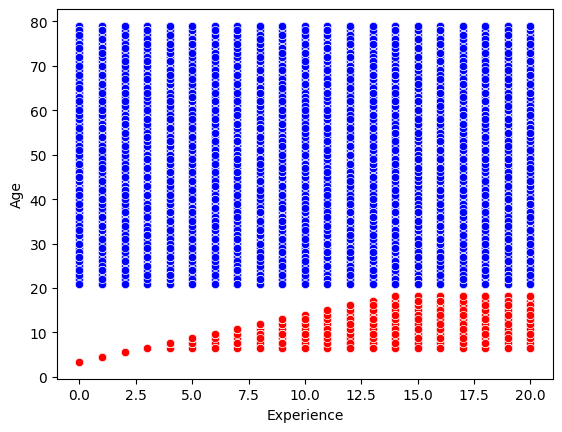

In [58]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Experience', y='Age', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Experience', y='PrediccionesRMAge', color="red", data=dataCuantitativas)


<Axes: xlabel='Income', ylabel='Age'>

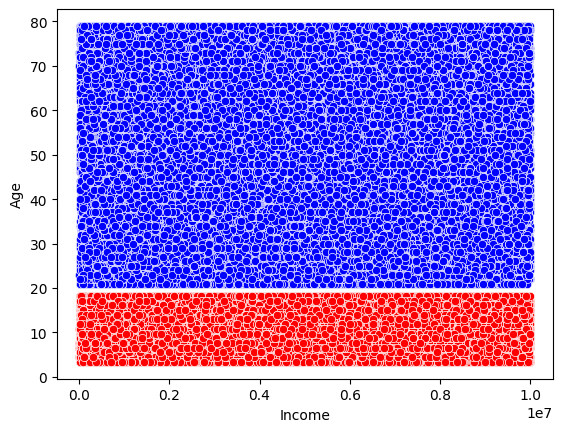

In [59]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Income', y='Age', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Income', y='PrediccionesRMAge', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_JOB_YRS', ylabel='Age'>

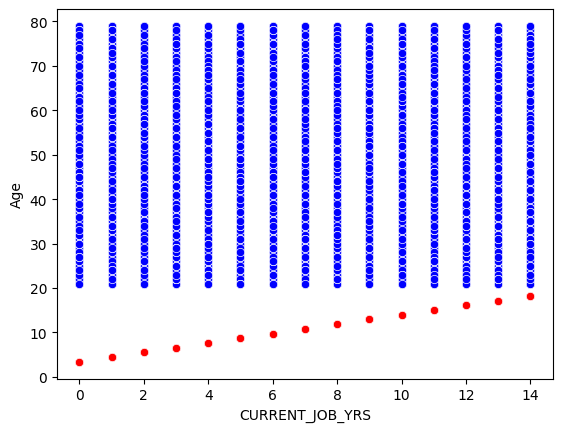

In [60]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_JOB_YRS', y='Age', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_JOB_YRS', y='PrediccionesRMAge', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_HOUSE_YRS', ylabel='Age'>

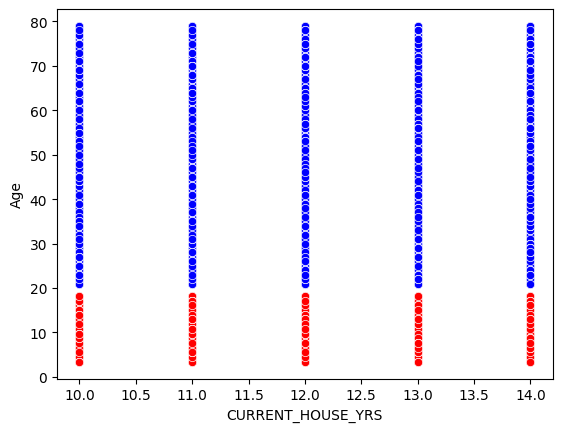

In [61]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_HOUSE_YRS', y='Age', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_HOUSE_YRS', y='PrediccionesRMAge', color="red", data=dataCuantitativas)


In [62]:
#Corroboramos cual es el coeficiente de Determinación de nuestro modelo
coef_DeterAge=modelAge.score(X=Vars_IndepAge, y=Var_DepAge)
print(f'Coeficiente de determinacion: {coef_DeterAge}')

Coeficiente de determinacion: 0.00041925413579979587


In [63]:
#Corroboramos cual es el coeficiente de Correlación de nuestro modelo
coef_CorrelAge=np.sqrt(coef_DeterAge)
print(f'Coeficiente de correlacion: {coef_CorrelAge}')

Coeficiente de correlacion: 0.020475696222590233


- 6.3 Variable Experience

In [64]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepExperience= dataCuantitativas[['Income', 'Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']]
Var_DepExperience= dataCuantitativas['Experience']

In [65]:
#Se define model como la función de regresión lineal
modelExperience= LinearRegression()

In [66]:
#Ajustamos el modelo con las variables antes declaradas
modelExperience.fit(X=Vars_IndepExperience, y=Var_DepExperience)

LinearRegression()

In [67]:
#Verificamos los coeficientes obtenidos para el modelo ajustado
modelExperience.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['Income', 'Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'],
       dtype=object),
 'n_features_in_': 4,
 'coef_': array([ 3.97750739e-09, -7.70413742e-04,  1.06324110e+00,  6.77864091e-02]),
 'rank_': 4,
 'singular_': array([1.44489779e+09, 8.56598103e+03, 1.83075721e+03, 7.02152073e+02]),
 'intercept_': 2.5553200475322857}

In [68]:
#Evaluamos la eficiencia del modelo obtenido por medio del coeficiente R Determinación
modelExperience.score(Vars_IndepExperience,Var_DepExperience)

0.4177012934333135

In [69]:
#Predecimos los valores de total de accidentes a partir de las variables: "alcohol", "speeding" y "no_previous"
y_predExperience= modelExperience.predict(X=dataCuantitativas[['Income', 'Age', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']])
y_predExperience

array([ 6.61373317, 13.00502443,  7.45117871, ..., 10.79399371,
        3.22439767, 10.72580621])

In [70]:
#Insertamos la columna de predicciones en el DataFrame
dataCuantitativas.insert(0, 'PrediccionesRMExperience', y_predExperience)
dataCuantitativas

,PrediccionesRMExperience,PrediccionesRMAge,PrediccionesRMIncome,PrediccionesRL,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,,,
1,6.613733,6.539208,4.971050e+06,6.539208,0,1303834,23,3,3,13
2,13.005024,12.919579,5.003419e+06,12.919579,0,7574516,40,10,9,13
3,7.451179,7.602603,4.986817e+06,7.602603,0,3991815,66,4,4,10
4,5.488537,5.475813,4.968571e+06,5.475813,1,6256451,41,2,2,12
5,6.680789,6.539208,4.975598e+06,6.539208,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...,...,...
251996,9.679725,9.729393,5.006359e+06,9.729393,0,8154883,43,13,6,11
251997,9.671697,9.729393,5.003681e+06,9.729393,0,2843572,26,10,6,11
251998,10.793994,10.792788,4.995333e+06,10.792788,0,4522448,46,7,7,12


<Axes: xlabel='Income', ylabel='Experience'>

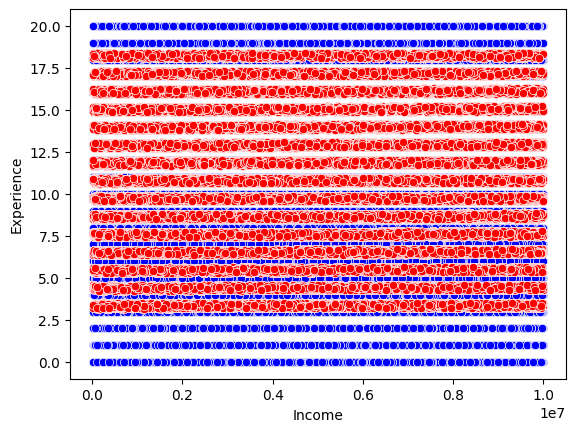

In [71]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Income', y='Experience', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Income', y='PrediccionesRMExperience', color="red", data=dataCuantitativas)


<Axes: xlabel='Age', ylabel='Experience'>

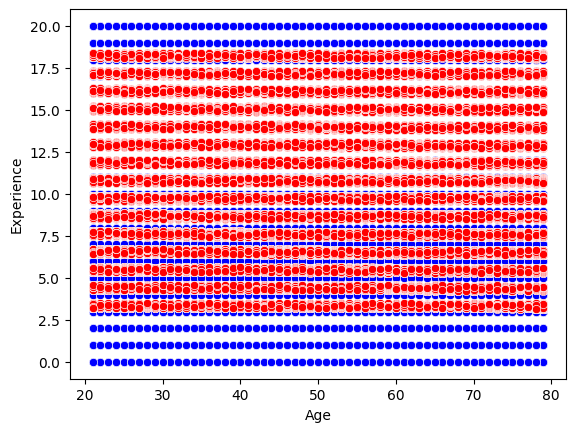

In [72]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Age', y='Experience', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Age', y='PrediccionesRMExperience', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_JOB_YRS', ylabel='Experience'>

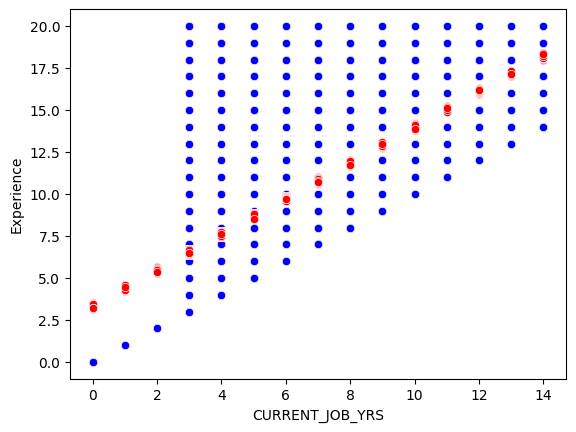

In [73]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_JOB_YRS', y='Experience', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_JOB_YRS', y='PrediccionesRMExperience', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_HOUSE_YRS', ylabel='Experience'>

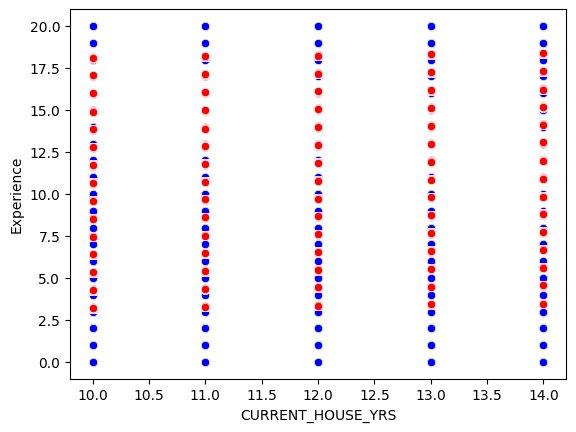

In [74]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_HOUSE_YRS', y='Experience', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_HOUSE_YRS', y='PrediccionesRMExperience', color="red", data=dataCuantitativas)


In [75]:
#Corroboramos cual es el coeficiente de Determinación de nuestro modelo
coef_DeterExperience=modelExperience.score(X=Vars_IndepExperience, y=Var_DepExperience)
print(f'Coeficiente de determinacion: {coef_DeterExperience}')

Coeficiente de determinacion: 0.4177012934333135


In [76]:
#Corroboramos cual es el coeficiente de Correlación de nuestro modelo
coef_CorrelExperience=np.sqrt(coef_DeterExperience)
print(f'Coeficiente de correlacion: {coef_CorrelExperience}')

Coeficiente de correlacion: 0.6462981459305864


- 6.4 Variable CURRENT_JOB_YRS

In [77]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepJob= dataCuantitativas[['Experience', 'Age', 'Income', 'CURRENT_HOUSE_YRS']]
Var_DepJob= dataCuantitativas['CURRENT_JOB_YRS']

In [78]:
#Se define model como la función de regresión lineal
modelJob= LinearRegression()

In [79]:
#Ajustamos el modelo con las variables antes declaradas
modelJob.fit(X=Vars_IndepJob, y=Var_DepJob)

LinearRegression()

In [80]:
#Verificamos los coeficientes obtenidos para el modelo ajustado
modelJob.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['Experience', 'Age', 'Income', 'CURRENT_HOUSE_YRS'], dtype=object),
 'n_features_in_': 4,
 'coef_': array([ 3.92629133e-01,  5.84908092e-04,  3.64881383e-09, -1.83627707e-02]),
 'rank_': 4,
 'singular_': array([1.44489779e+09, 8.56598083e+03, 3.01323818e+03, 7.02025847e+02]),
 'intercept_': 2.5472940691652894}

In [81]:
#Evaluamos la eficiencia del modelo obtenido por medio del coeficiente R Determinación
modelJob.score(Vars_IndepJob,Var_DepJob)

0.4175082512923083

In [82]:
#Predecimos los valores de total de accidentes a partir de las variables: "alcohol", "speeding" y "no_previous"
y_predJob= modelJob.predict(X=dataCuantitativas[['Experience', 'Age', 'Income', 'CURRENT_HOUSE_YRS']])
y_predJob

array([3.50467578, 6.2859037 , 3.98735222, ..., 5.11875209, 2.41373053,
       9.09403799])

In [83]:
#Insertamos la columna de predicciones en el DataFrame
dataCuantitativas.insert(0, 'PrediccionesRMJob', y_predJob)
dataCuantitativas

,PrediccionesRMJob,PrediccionesRMExperience,PrediccionesRMAge,PrediccionesRMIncome,PrediccionesRL,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,,,,
1,3.504676,6.613733,6.539208,4.971050e+06,6.539208,0,1303834,23,3,3,13
2,6.285904,13.005024,12.919579,5.003419e+06,12.919579,0,7574516,40,10,9,13
3,3.987352,7.451179,7.602603,4.986817e+06,7.602603,0,3991815,66,4,4,10
4,3.159009,5.488537,5.475813,4.968571e+06,5.475813,1,6256451,41,2,2,12
5,6.657676,6.680789,6.539208,4.975598e+06,6.539208,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...,...,...,...
251996,7.504389,9.679725,9.729393,5.006359e+06,9.729393,0,8154883,43,13,6,11
251997,6.297178,9.671697,9.729393,5.003681e+06,9.729393,0,2843572,26,10,6,11
251998,5.118752,10.793994,10.792788,4.995333e+06,10.792788,0,4522448,46,7,7,12


<Axes: xlabel='Experience', ylabel='CURRENT_JOB_YRS'>

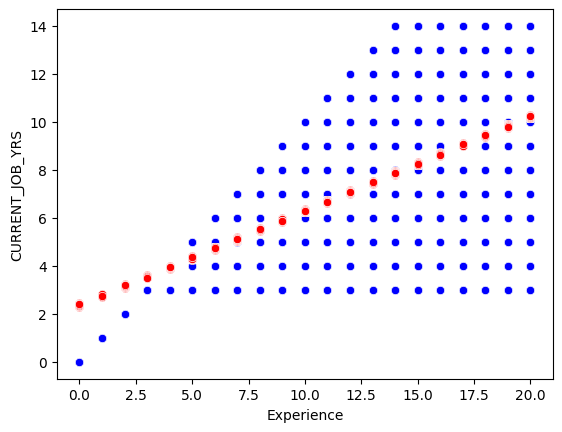

In [84]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Experience', y='CURRENT_JOB_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Experience', y='PrediccionesRMJob', color="red", data=dataCuantitativas)


<Axes: xlabel='Age', ylabel='CURRENT_JOB_YRS'>

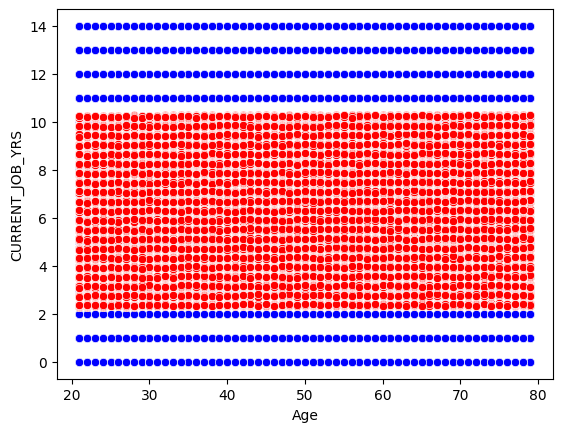

In [85]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Age', y='CURRENT_JOB_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Age', y='PrediccionesRMJob', color="red", data=dataCuantitativas)


<Axes: xlabel='Income', ylabel='CURRENT_JOB_YRS'>

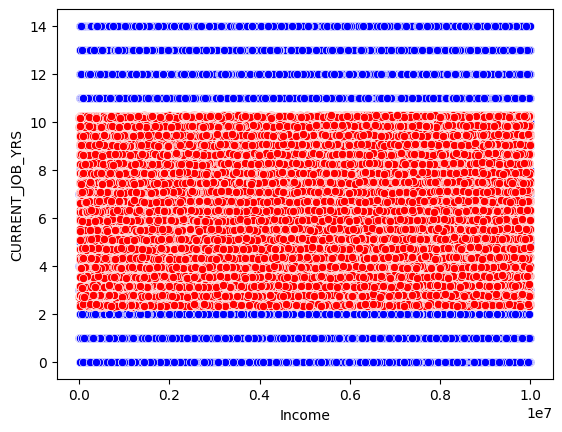

In [86]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Income', y='CURRENT_JOB_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Income', y='PrediccionesRMJob', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_HOUSE_YRS', ylabel='CURRENT_JOB_YRS'>

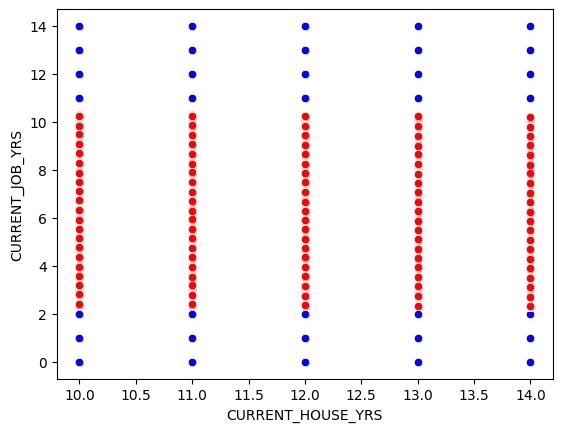

In [87]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_HOUSE_YRS', y='CURRENT_JOB_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_HOUSE_YRS', y='PrediccionesRMJob', color="red", data=dataCuantitativas)


In [88]:
#Corroboramos cual es el coeficiente de Determinación de nuestro modelo
coef_DeterJob=modelJob.score(X=Vars_IndepJob, y=Var_DepJob)
print(f'Coeficiente de determinacion: {coef_DeterJob}')

Coeficiente de determinacion: 0.4175082512923083


In [89]:
#Corroboramos cual es el coeficiente de Correlación de nuestro modelo
coef_CorrelJob=np.sqrt(coef_DeterJob)
print(f'Coeficiente de correlacion: {coef_CorrelJob}')

Coeficiente de correlacion: 0.6461487841761434


- 6.5 Variable CURRENT_HOUSE_YRS

In [90]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepHouse= dataCuantitativas[['Experience', 'Age', 'CURRENT_JOB_YRS', 'Income']]
Var_DepHouse= dataCuantitativas['CURRENT_HOUSE_YRS']

In [91]:
#Se define model como la función de regresión lineal
modelHouse= LinearRegression()

In [92]:
#Ajustamos el modelo con las variables antes declaradas
modelHouse.fit(X=Vars_IndepHouse, y=Var_DepHouse)

LinearRegression()

In [93]:
#Verificamos los coeficientes obtenidos para el modelo ajustado
modelHouse.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['Experience', 'Age', 'CURRENT_JOB_YRS', 'Income'], dtype=object),
 'n_features_in_': 4,
 'coef_': array([ 6.31830185e-03, -1.64629730e-03, -4.63495144e-03, -1.21479702e-09]),
 'rank_': 4,
 'singular_': array([1.44489779e+09, 8.56596994e+03, 3.28446072e+03, 1.28194548e+03]),
 'intercept_': 12.051744084441737}

In [94]:
#Evaluamos la eficiencia del modelo obtenido por medio del coeficiente R Determinación
modelHouse.score(Vars_IndepHouse,Var_DepHouse)

0.0008688150174576137

In [95]:
#Predecimos los valores de total de accidentes a partir de las variables: "alcohol", "speeding" y "no_previous"
y_predHouse= modelHouse.predict(X=dataCuantitativas[['Experience', 'Age', 'CURRENT_JOB_YRS', 'Income']])
y_predHouse

array([12.0173454 , 11.99815915, 11.94497262, ..., 11.98230401,
       11.96975587, 12.00045126])

In [96]:
#Insertamos la columna de predicciones en el DataFrame
dataCuantitativas.insert(0, 'PrediccionesRMHouse', y_predHouse)
dataCuantitativas

,PrediccionesRMHouse,PrediccionesRMJob,PrediccionesRMExperience,PrediccionesRMAge,PrediccionesRMIncome,PrediccionesRL,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,,,,,
1,12.017345,3.504676,6.613733,6.539208,4.971050e+06,6.539208,0,1303834,23,3,3,13
2,11.998159,6.285904,13.005024,12.919579,5.003419e+06,12.919579,0,7574516,40,10,9,13
3,11.944973,3.987352,7.451179,7.602603,4.986817e+06,7.602603,0,3991815,66,4,4,10
4,11.980012,3.159009,5.488537,5.475813,4.968571e+06,5.475813,1,6256451,41,2,2,12
5,12.022957,6.657676,6.680789,6.539208,4.975598e+06,6.539208,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,12.025375,7.504389,9.679725,9.729393,5.006359e+06,9.729393,0,8154883,43,13,6,11
251997,12.040859,6.297178,9.671697,9.729393,5.003681e+06,9.729393,0,2843572,26,10,6,11
251998,11.982304,5.118752,10.793994,10.792788,4.995333e+06,10.792788,0,4522448,46,7,7,12


<Axes: xlabel='Experience', ylabel='CURRENT_HOUSE_YRS'>

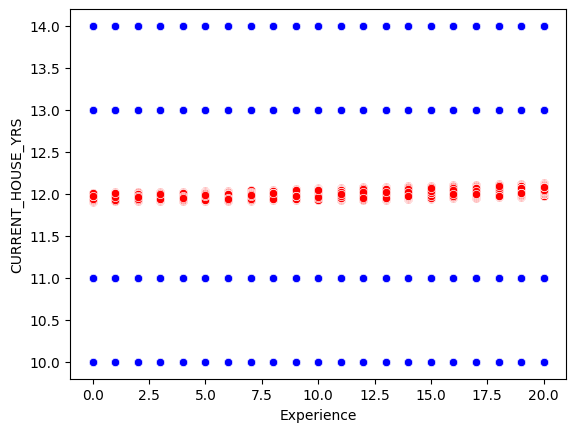

In [97]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Experience', y='CURRENT_HOUSE_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Experience', y='PrediccionesRMHouse', color="red", data=dataCuantitativas)


<Axes: xlabel='Age', ylabel='CURRENT_HOUSE_YRS'>

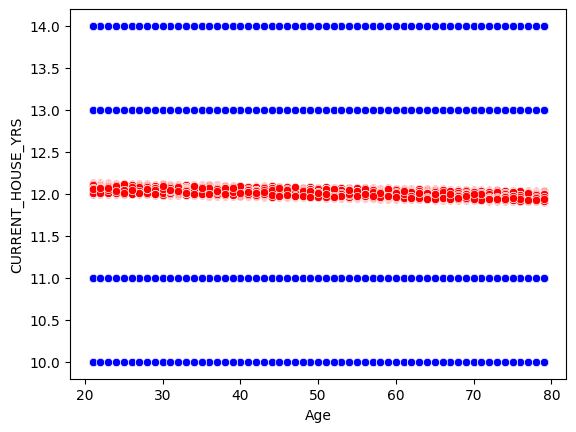

In [98]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Age', y='CURRENT_HOUSE_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Age', y='PrediccionesRMHouse', color="red", data=dataCuantitativas)


<Axes: xlabel='CURRENT_JOB_YRS', ylabel='CURRENT_HOUSE_YRS'>

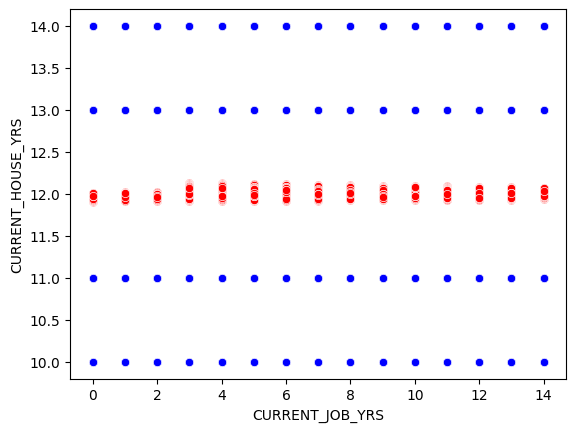

In [99]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='CURRENT_JOB_YRS', y='CURRENT_HOUSE_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='CURRENT_JOB_YRS', y='PrediccionesRMHouse', color="red", data=dataCuantitativas)


<Axes: xlabel='Income', ylabel='CURRENT_HOUSE_YRS'>

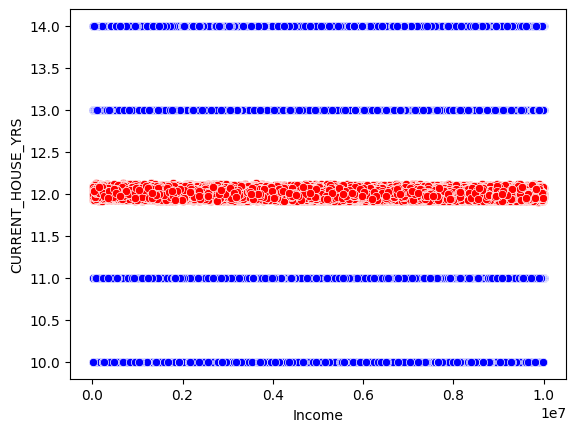

In [100]:
#Visualizamos la gráfica comparativa entre el total real y el total predecido

sns.scatterplot(x='Income', y='CURRENT_HOUSE_YRS', color="blue", data=dataCuantitativas)
sns.scatterplot(x='Income', y='PrediccionesRMHouse', color="red", data=dataCuantitativas)


In [101]:
#Corroboramos cual es el coeficiente de Determinación de nuestro modelo
coef_DeterHouse=modelHouse.score(X=Vars_IndepHouse, y=Var_DepHouse)
print(f'Coeficiente de determinacion: {coef_DeterHouse}')

Coeficiente de determinacion: 0.0008688150174576137


In [102]:
#Corroboramos cual es el coeficiente de Correlación de nuestro modelo

# Notaaaa. La correlacion de CURRENT_HOUSE_YRS si mejora a comparacion al heatmap
# en el mapa de calor el max es de 0.02 y aqui es de 0.03



coef_CorrelHouse=np.sqrt(coef_DeterHouse)
print(f'Coeficiente de correlacion: {coef_CorrelHouse}')

Coeficiente de correlacion: 0.029475668227499332


### 7. Regresion no lineal

In [270]:
def  funInversa (x, a):
     return 1 / (a*x)

def funCocPol (x, a, b, c):
     return (a*x**2 + b)/ (c*x)

def funCuadratica(x, a, b, c):
     return a*x**2 + b*x + c

def funAbs(x, a, b, c):
     return a*np.abs(x) + b*x + c

def funSin(x, a, b):
     return a*np.sin(x) + b 

def funTan(x, a, b):
     return a*np.tan(x) + b 

def funLog(x, a, b):
     return a*np.log(x) + b 

def funCuaInv(x, a):
     return 1/a*x**2

- 7.1 Variable Income

In [129]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepIncomeRNL= dataCuantitativas[['Age']]
Var_DepIncomeRNL= dataCuantitativas['Income']

In [130]:
#Redefinimos las variables 
xIncomeRNL= Vars_IndepIncomeRNL
yIncomeRNL= Var_DepIncomeRNL

In [186]:
#Ajustamos los parámetros de la función curve_fit
parametrosIncomeRNL, covsIncomeRNL= curve_fit(funSin, dataCuantitativas['Age'], dataCuantitativas['Income'])
aIncomeRNL,bIncomeRNL = parametrosIncomeRNL[ 0 ], parametrosIncomeRNL[ 1 ]
yfitIncomeRNL = aIncomeRNL*np.sin(xIncomeRNL) + bIncomeRNL

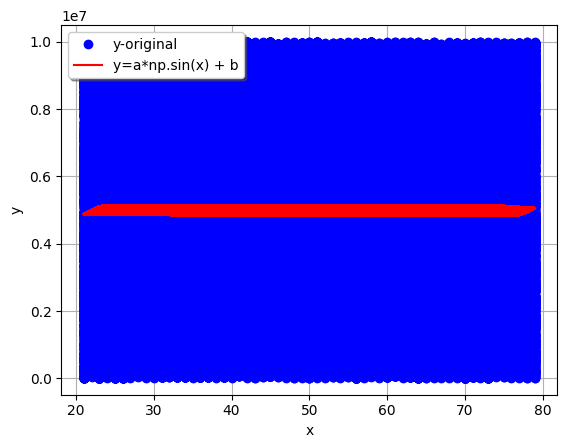

In [201]:
#Graficamos las predicciones y los datos originales para realizar la comparación
plt.plot(xIncomeRNL, yIncomeRNL, 'bo', label="y-original")
plt.plot(xIncomeRNL, yfitIncomeRNL, label="y=a*np.sin(x) + b", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [188]:
# Calculamos el coeficiente de determinación del modelo
r2IncomeRNL = r2_score(yIncomeRNL, yfitIncomeRNL) 
print(f'Coeficiente de determinacion: {r2IncomeRNL}')

Coeficiente de determinacion: 0.0012110706289841788


In [190]:
# Calculamos el coeficiente de correlacion del modelo

# En este caso mejoró el coef de corr, siendo que en el heatmap es de 0.00 y 
# con una funcion senoidal mejora a 0.03

rIncomeRNL=np.sqrt(r2IncomeRNL)
print(f'Coeficiente de correlacion: {rIncomeRNL}')

Coeficiente de correlacion: 0.034800440068829284


- 7.2 Variable CURRENT_HOUSE_YRS

In [228]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepHouseRNL= dataCuantitativas[['Age']]
Var_DepHouseRNL= dataCuantitativas['CURRENT_HOUSE_YRS']

In [229]:
#Redefinimos las variables 
xHouseRNL= Vars_IndepHouseRNL
yHouseRNL= Var_DepHouseRNL

In [230]:
#Ajustamos los parámetros de la función curve_fit
parametrosHouseRNL, covsHouseRNL= curve_fit(funSin, dataCuantitativas['Age'], dataCuantitativas['CURRENT_HOUSE_YRS'])
# aHouseRNL, bHouseRNL, cHouseRNL = parametrosHouseRNL[ 0 ], parametrosHouseRNL[ 1 ], parametrosHouseRNL[ 2 ]
aHouseRNL, bHouseRNL = parametrosHouseRNL[ 0 ], parametrosHouseRNL[ 1 ]

yfitHouseRNL = aHouseRNL*np.sin(xHouseRNL) + bHouseRNL

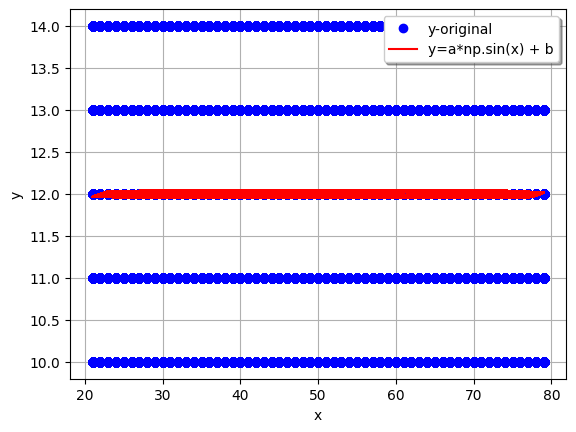

In [234]:
#Graficamos las predicciones y los datos originales para realizar la comparación
plt.plot(xHouseRNL, yHouseRNL, 'bo', label="y-original")
plt.plot(xHouseRNL, yfitHouseRNL, label="y=a*np.sin(x) + b", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [232]:
# Calculamos el coeficiente de determinación del modelo
r2HouseRNL = r2_score(yHouseRNL, yfitHouseRNL) 
print(f'Coeficiente de determinacion: {r2HouseRNL}')

Coeficiente de determinacion: 0.0003694726336431753


In [233]:
# Calculamos el coeficiente de correlacion del modelo
rHouseRNL=np.sqrt(r2HouseRNL)

# En este caso no se encontró modelo que mejorara el factor de correlacion

print(f'Coeficiente de correlacion: {rHouseRNL}')

Coeficiente de correlacion: 0.01922167093785489


- 7.3 Variable CURRENT_JOB_YRS

In [157]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepJobRNL= dataCuantitativas[['Age']]
Var_DepJobRNL= dataCuantitativas['CURRENT_JOB_YRS']

In [158]:
#Redefinimos las variables 
xJobRNL= Vars_IndepJobRNL
yJobRNL= Var_DepJobRNL

In [177]:
#Ajustamos los parámetros de la función curve_fit
parametrosJobRNL, covsJobRNL= curve_fit(funSin, dataCuantitativas['Age'], dataCuantitativas['CURRENT_JOB_YRS'])
# aJobRNL, bJobRNL, cJobRNL = parametrosJobRNL[ 0 ], parametrosJobRNL[ 1 ], parametrosJobRNL[ 2 ]
aJobRNL, bJobRNL = parametrosJobRNL[ 0 ], parametrosJobRNL[ 1 ]
yfitJobRNL = aJobRNL*np.sin(xJobRNL) + bJobRNL 

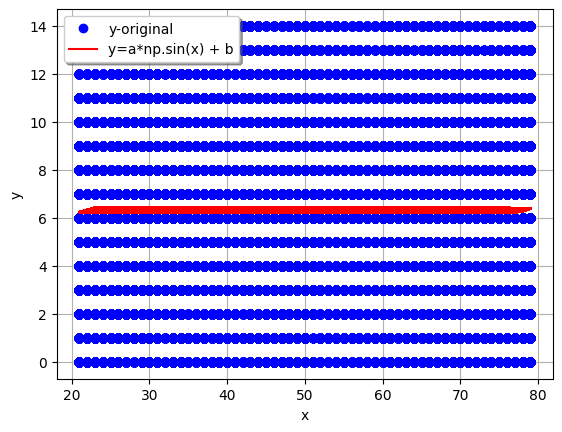

In [235]:
#Graficamos las predicciones y los datos originales para realizar la comparación
plt.plot(xJobRNL, yJobRNL, 'bo', label="y-original")
plt.plot(xJobRNL, yfitJobRNL, label="y=a*np.sin(x) + b", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [179]:
# Calculamos el coeficiente de determinación del modelo
r2JobRNL = r2_score(yJobRNL, yfitJobRNL) 
print(f'Coeficiente de determinacion: {r2JobRNL}')

Coeficiente de determinacion: 0.00042208725262671276


In [180]:
# Calculamos el coeficiente de correlacion del modelo

# En este caso mejoró el coef de corr, siendo que en el heatmap es de 0.00 y 
# con una funcion senoidal mejora a 0.02

rJobRNL=np.sqrt(r2JobRNL)
print(f'Coeficiente de correlacion: {rJobRNL}')

Coeficiente de correlacion: 0.020544762170118025


- 7.4 Variable Experience

In [237]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepExperienceRNL= dataCuantitativas[['Age']]
Var_DepExperienceRNL= dataCuantitativas['Experience']

In [238]:
#Redefinimos las variables 
xExperienceRNL= Vars_IndepExperienceRNL
yExperienceRNL= Var_DepExperienceRNL

In [239]:
#Ajustamos los parámetros de la función curve_fit
parametrosExperienceRNL, covsExperienceRNL= curve_fit(funSin, dataCuantitativas['Age'], dataCuantitativas['Experience'])
aExperienceRNL, bExperienceRNL = parametrosExperienceRNL[ 0 ], parametrosExperienceRNL[ 1 ]

yfitExperienceRNL = aExperienceRNL*np.sin(xExperienceRNL) + bExperienceRNL

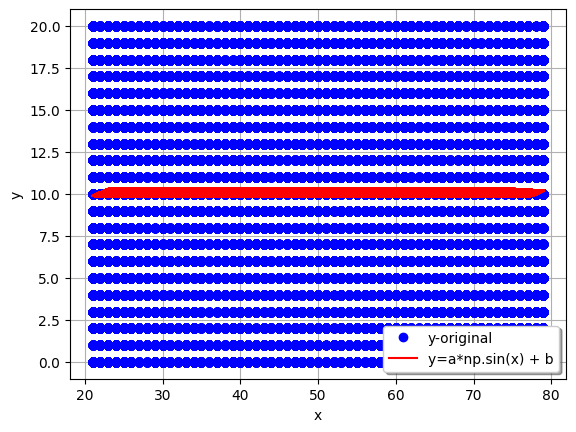

In [240]:
#Graficamos las predicciones y los datos originales para realizar la comparación
plt.plot(xExperienceRNL, yExperienceRNL, 'bo', label="y-original")
plt.plot(xExperienceRNL, yfitExperienceRNL, label="y=a*np.sin(x) + b", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [241]:
# Calculamos el coeficiente de determinación del modelo
r2ExperienceRNL = r2_score(yExperienceRNL, yfitExperienceRNL) 
print(f'Coeficiente de determinacion: {r2ExperienceRNL}')

Coeficiente de determinacion: 0.0008181516979579584


In [242]:
# Calculamos el coeficiente de correlacion del modelo
rExperienceRNL=np.sqrt(r2ExperienceRNL)

# En este caso mejoró el coef de corr, siendo que en el heatmap es de 0.00 y 
# con una funcion senoidal mejora a 0.02

print(f'Coeficiente de correlacion: {rExperienceRNL}')

Coeficiente de correlacion: 0.02860335116656715


- 7.5 Variable Age

In [271]:
#Declaramos las variables dependientes e independientes para la regresión lineal
Vars_IndepAgeRNL= dataCuantitativas[['CURRENT_JOB_YRS']]
Var_DepAgeRNL= dataCuantitativas['Age']

In [272]:
#Redefinimos las variables 
xAgeRNL= Vars_IndepAgeRNL
yAgeRNL= Var_DepAgeRNL

In [278]:
#Ajustamos los parámetros de la función curve_fit
parametrosAgeRNL, covsAgeRNL= curve_fit(funSin, dataCuantitativas['CURRENT_JOB_YRS'], dataCuantitativas['Age'])
aAgeRNL, bAgeRNL = parametrosAgeRNL[ 0 ], parametrosAgeRNL[ 1 ]

yfitAgeRNL = aAgeRNL*np.sin(xAgeRNL) + bAgeRNL

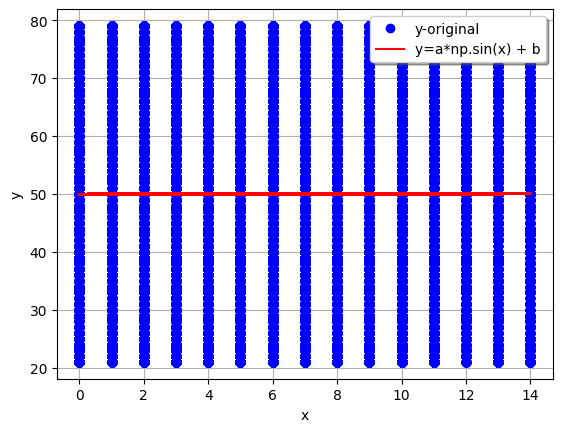

In [279]:
#Graficamos las predicciones y los datos originales para realizar la comparación
plt.plot(xAgeRNL, yAgeRNL, 'bo', label="y-original")
plt.plot(xAgeRNL, yfitAgeRNL, label="y=a*np.sin(x) + b", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [280]:
# Calculamos el coeficiente de determinación del modelo
r2AgeRNL = r2_score(yAgeRNL, yfitAgeRNL) 
print(f'Coeficiente de determinacion: {r2AgeRNL}')

Coeficiente de determinacion: 2.03051040829072e-05


In [281]:
# Calculamos el coeficiente de correlacion del modelo
rAgeRNL=np.sqrt(r2AgeRNL)

# En este caso no se encontró modelo que mejorara el factor de correlacion

print(f'Coeficiente de correlacion: {rAgeRNL}')

Coeficiente de correlacion: 0.004506118516296171
